# Fixes need to do:
## we need to fix the vanishing calcaulations in the nets, maybe amplifying all the values by some factor (100 maybe to get to normal values) and in the end we can just shrink the result (only the output) in the real test

## Add the normalization (around 0) of the the outputs - if the nets doesn't do it naturally

## Maybe initialize the weights to a big number because all the values are very small

## Add the scipy snippet to resample the vectors to be the same vector (DONE)

## MAYBE change the fully connected layers to go from each cell to an output instead of merging all the outputs to a big vector and forwarding it through a big FC

# Libraries Imports

In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os
import string 
# from google.colab import drive
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
from data import *
from Nets import device
import Nets
import hyper_parameters as hp
from Data_Handling import *
import training
from training import calc_loss

checking for device (GPU)

In [3]:
# drive.mount('/content/drive')
print('training on: ',device)


training on:  cuda


In [3]:
mod = Nets.load_model_from_mode('doppler', True, 0.5, 0.0001, name='together').to(device)
mod_sep = Nets.load_model_from_mode('doppler', True, 0.5, 0.00011).to(device)

In [42]:
pepe = Nets.load_model_from_mode('spectra', True, 0.7, 5e-6).to(device)
# print(pepe)

In [43]:
training.check_spectra_model(pepe, train_loader)
training.check_spectra_model(pepe, val_loader)
training.check_spectra_model(pepe, test_loader)

Loss: 0.2452...
Loss: 0.2459...
Loss: 0.2504...


0.2504271636051791

In [20]:
training.check_spectra_model(pepe, train_loader)

Loss: 0.2452...


0.24518773713532616

# Data Pre-Processing

In [5]:
def get_sizes(train, test, val):
    iterator = iter(train)
    it1 = next(iterator)
    obs, ground_truth, sys_id, times, velocities = it1
    print(obs.shape, obs.type()) # observations: Obs_amount X wave_amount
    print(ground_truth.shape, ground_truth.type()) # Ground Truth Spectras: stars_amount (2) X wave_output_amount
    print(sys_id) # System ID: int
    print(times.shape, times.type()) # Time of sample: Obs_amount
    print(velocities.shape, velocities.type()) # Velocities per sample time: stars_amount (2) X Obs_amount
    Obs_amount, wave_amount, wave_output = obs.shape[0], obs.shape[1], ground_truth.shape[1]
    return Obs_amount, wave_amount, wave_output

In [4]:
# dataset = SpectraDataset()
train_loader, test_loader, val_loader, std_dict = getLoader(seed=1)

In [7]:
print(std_dict)

{'min source': 4992.544013409346, 'max source': 5087.104146943163, 'min target': 4990.122000000003, 'max target': 5079.972000001964, 'source len': 7500, 'target len': 1700, 'vector source': array([4992.54401341, 4992.55662311, 4992.56923281, ..., 5087.07892754,
       5087.09153724, 5087.10414694]), 'vector target': array([4990.122     , 4990.17488405, 4990.2277681 , ..., 5079.8662319 ,
       5079.91911595, 5079.972     ])}


# The Training - SpectraNet
### 1. sum the losses
of each spectra and then backprop - I think it will backprop in the net twice (for each spectra)
### 2. train 
the first layers until spectra1 and then only the last FC on the spectra2 with all the others params grad's are off

In [39]:
spectr = Nets.SpectraNet(drop=0.7).to(device)


In [40]:

epochs_amount = 15
opt = optim.Adam(spectr.parameters(), weight_decay = 1e-1, lr=5e-5) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//5)+1 and (epoch+1)%2 == 0 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
spectr, train_loss, val_loss = training.train_spectra1(spectr, opt, sched, train_loader, val_loader, epochs=epochs_amount)
training.check_spectra_model(spectr, train_loader)
training.check_spectra_model(spectr, val_loader)
training.check_spectra_model(spectr, test_loader)

Epoch: 1/15... Train Loss: 1.5609... Validation Loss: 1.3937... LR: [5e-05]
Epoch: 2/15... Train Loss: 0.5526... Validation Loss: 0.2874... LR: [5e-05]
Epoch: 3/15... Train Loss: 0.2688... Validation Loss: 0.2623... LR: [5e-05]
Epoch: 4/15... Train Loss: 0.2541... Validation Loss: 0.2530... LR: [2.5e-05]
Epoch: 5/15... Train Loss: 0.2521... Validation Loss: 0.2558... LR: [2.5e-05]
Epoch: 6/15... Train Loss: 0.2490... Validation Loss: 0.2440... LR: [1.25e-05]
Epoch: 7/15... Train Loss: 0.2509... Validation Loss: 0.2433... LR: [1.25e-05]
Epoch: 8/15... Train Loss: 0.2467... Validation Loss: 0.2425... LR: [6.25e-06]
Epoch: 9/15... Train Loss: 0.2469... Validation Loss: 0.2420... LR: [6.25e-06]
Epoch: 10/15... Train Loss: 0.2414... Validation Loss: 0.2422... LR: [3.125e-06]
Epoch: 11/15... Train Loss: 0.2428... Validation Loss: 0.2402... LR: [3.125e-06]
Epoch: 12/15... Train Loss: 0.2417... Validation Loss: 0.2408... LR: [1.5625e-06]
Epoch: 13/15... Train Loss: 0.2415... Validation Loss: 0

0.24114310209240233

Loss: 0.2373...


0.23730858047218883

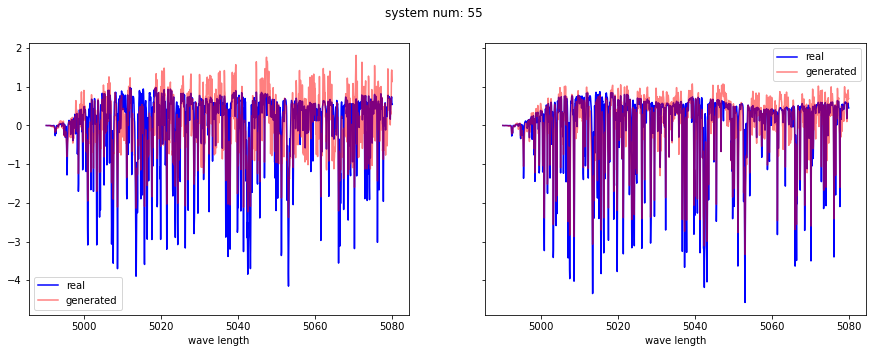

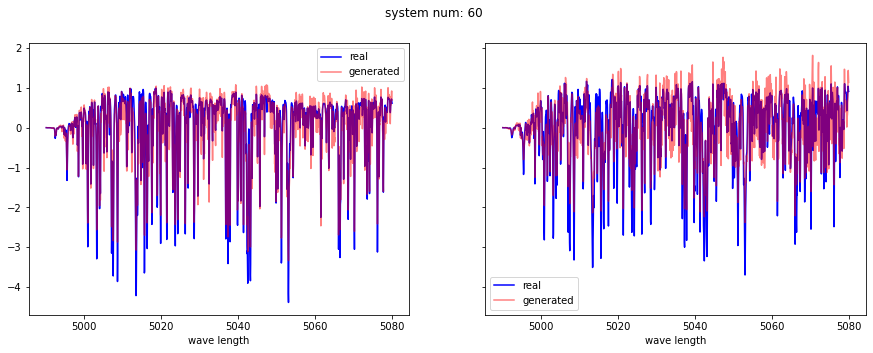

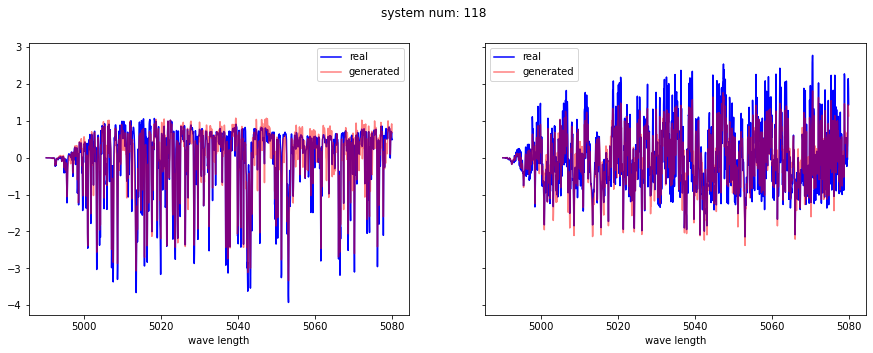

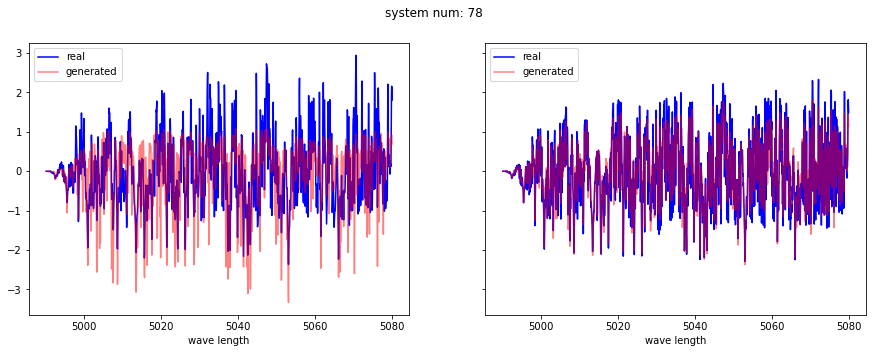

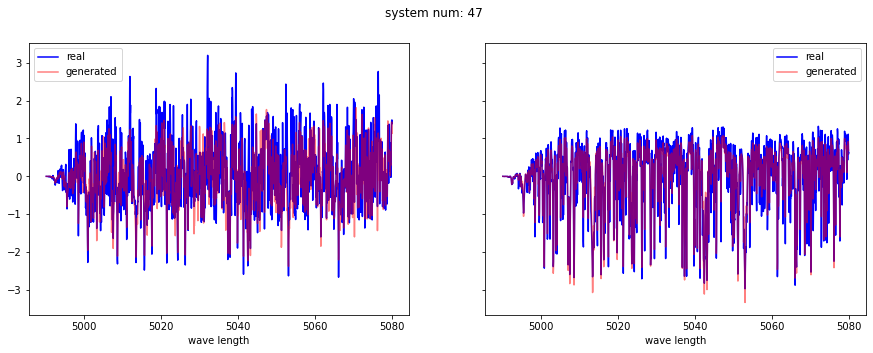

In [41]:
training.check_spectra_model(spectr, train_loader, 5, std_dict['vector target'])

# Train - DopplerNet

In [18]:
dop_test = Nets.DopplerNet(drop=0.5).to(device)

In [ ]:
h = dop_test.init_hidden()
print(len(h), h[0].shape, h[1].shape)

In [19]:
epochs_amount = 15
opt = optim.Adam(dop_test.parameters(), weight_decay = 1e-2,lr=0.0001) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
dop_test, train_loss, val_loss = train_doppler_together25(pepe, dop_test, opt, sched, train_loader, val_loader, epochs=epochs_amount)


Epoch: 1/15... Train Loss: 114.8926... Validation Loss: 120.7075... LR: [0.0001]
Epoch: 2/15... Train Loss: 73.8749... Validation Loss: 44.3770... LR: [0.0001]
Epoch: 3/15... Train Loss: 40.0318... Validation Loss: 41.3694... LR: [0.0001]
Epoch: 4/15... Train Loss: 32.0845... Validation Loss: 42.4336... LR: [0.0001]
Epoch: 5/15... Train Loss: 30.8360... Validation Loss: 38.2371... LR: [0.0001]
Epoch: 6/15... Train Loss: 29.3252... Validation Loss: 36.1075... LR: [0.0001]
Epoch: 7/15... Train Loss: 28.6689... Validation Loss: 34.7722... LR: [0.0001]
Epoch: 8/15... Train Loss: 26.7246... Validation Loss: 38.4778... LR: [0.0001]
Epoch: 9/15... Train Loss: 25.3704... Validation Loss: 33.8409... LR: [0.0001]
Epoch: 10/15... Train Loss: 23.6663... Validation Loss: 32.0080... LR: [5e-05]
Epoch: 11/15... Train Loss: 23.5905... Validation Loss: 30.2300... LR: [5e-05]
Epoch: 12/15... Train Loss: 22.8342... Validation Loss: 28.7088... LR: [2.5e-05]
Epoch: 13/15... Train Loss: 21.9271... Validatio

Spectra Loss: 0.2504... Doppler Loss: 23.1957...


(0.2504271636051791, 23.19573940549578)

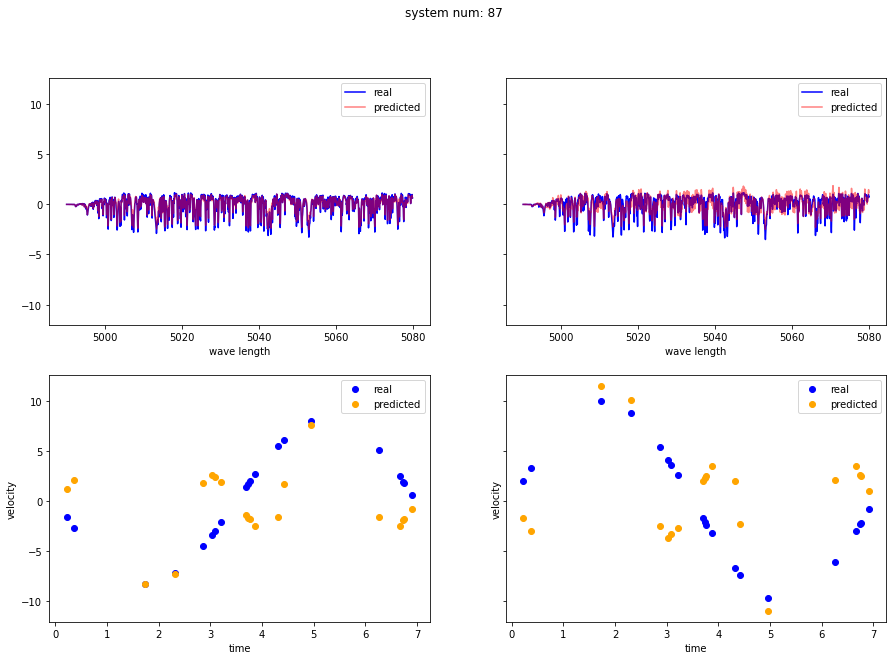

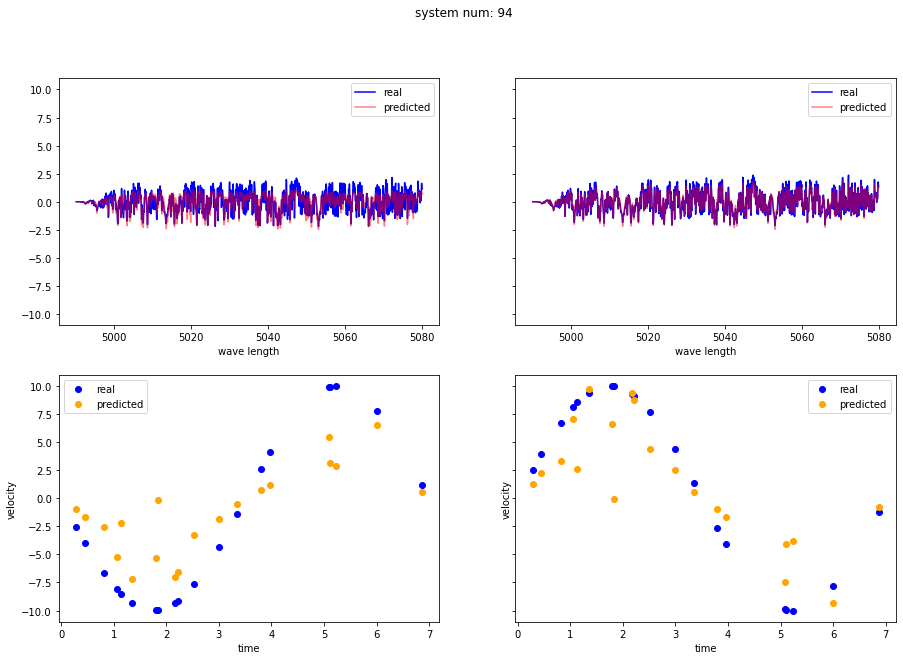

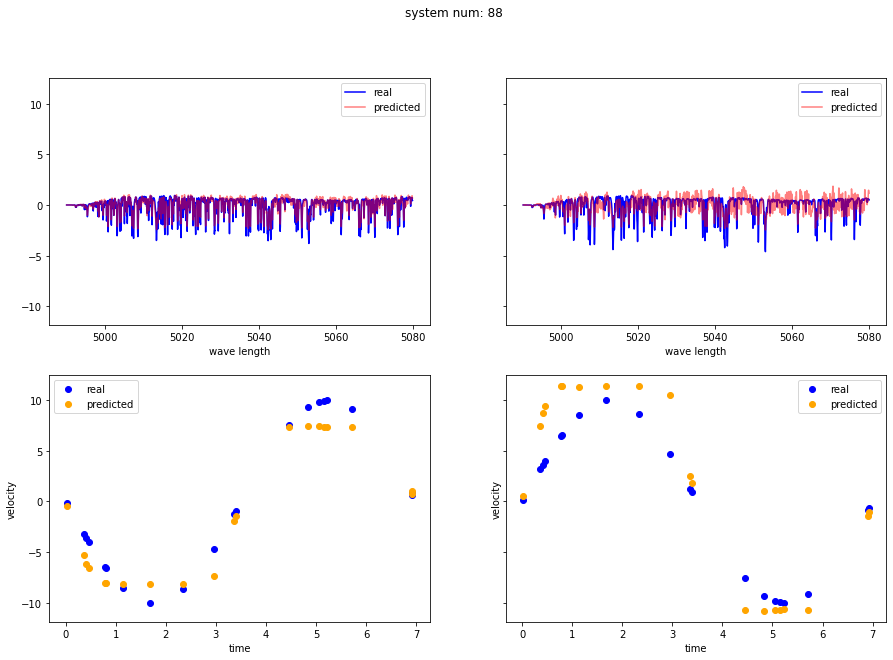

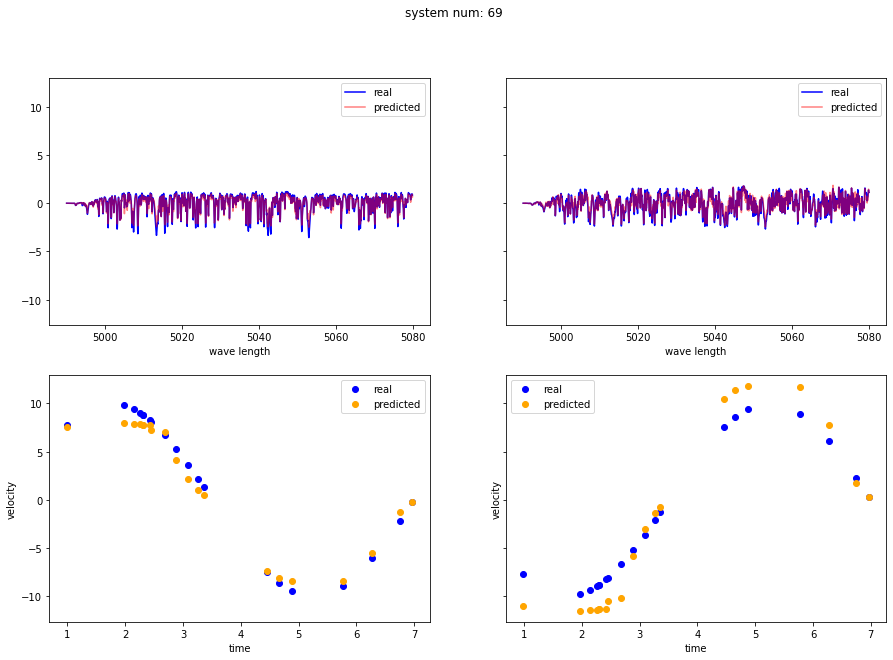

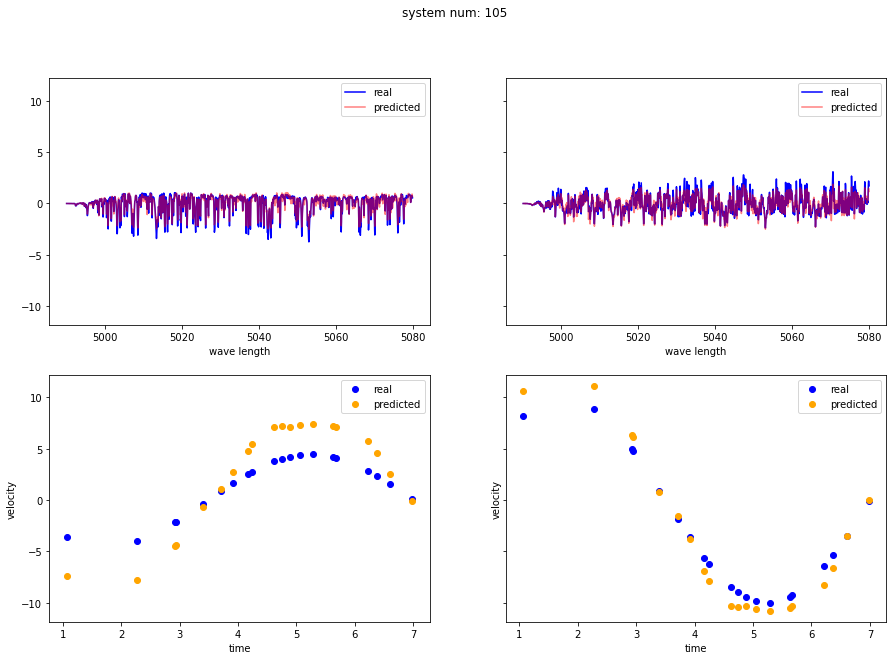

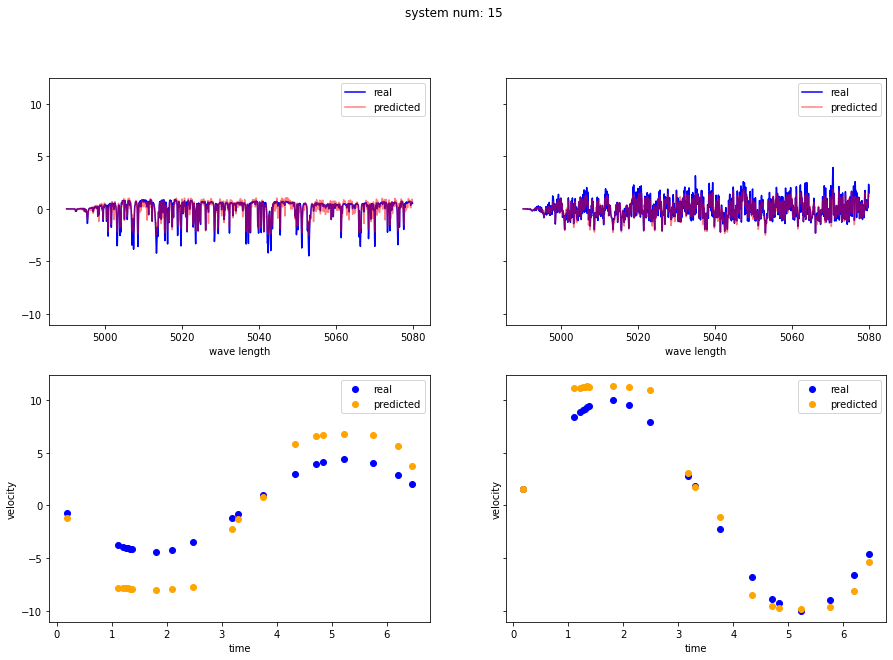

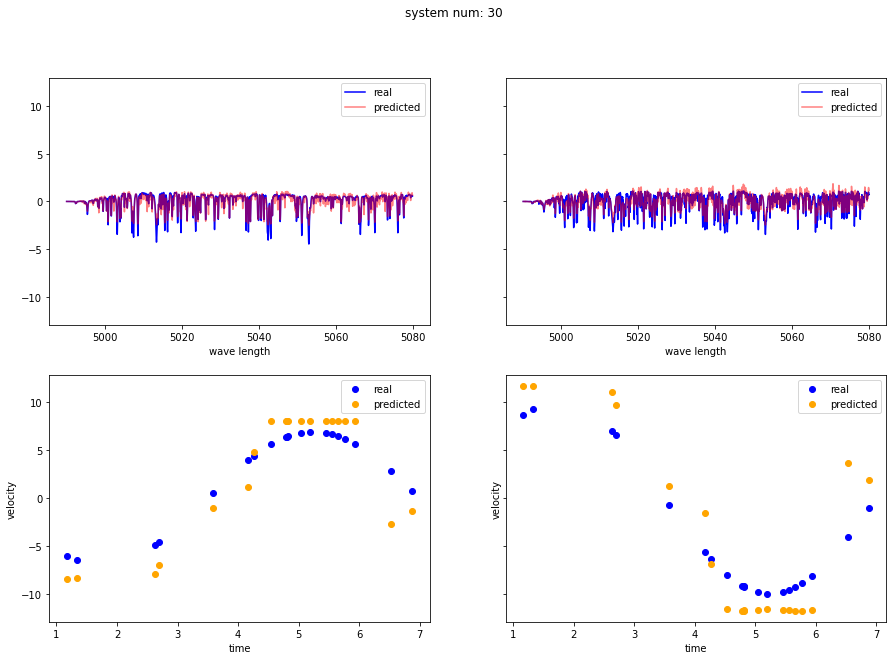

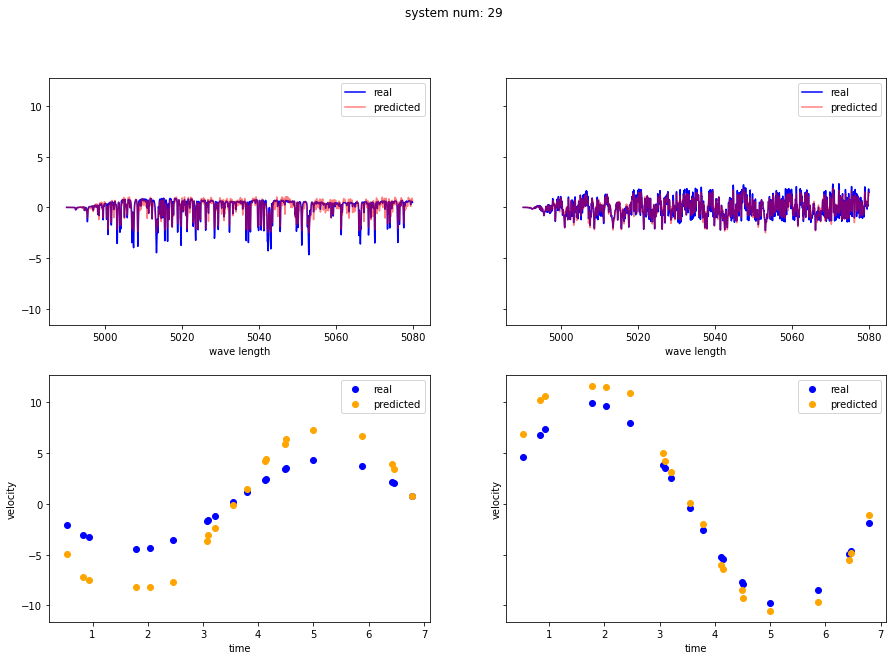

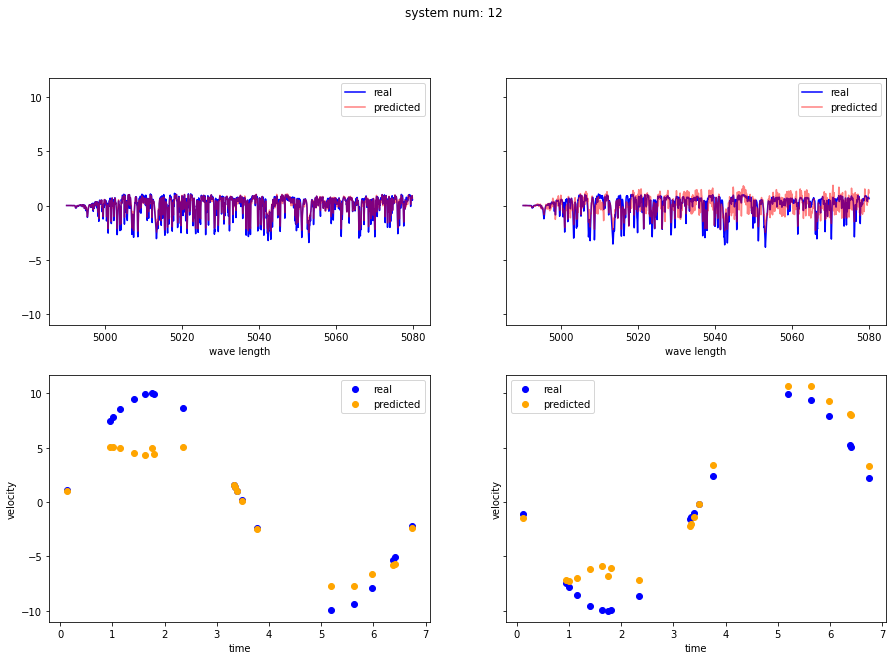

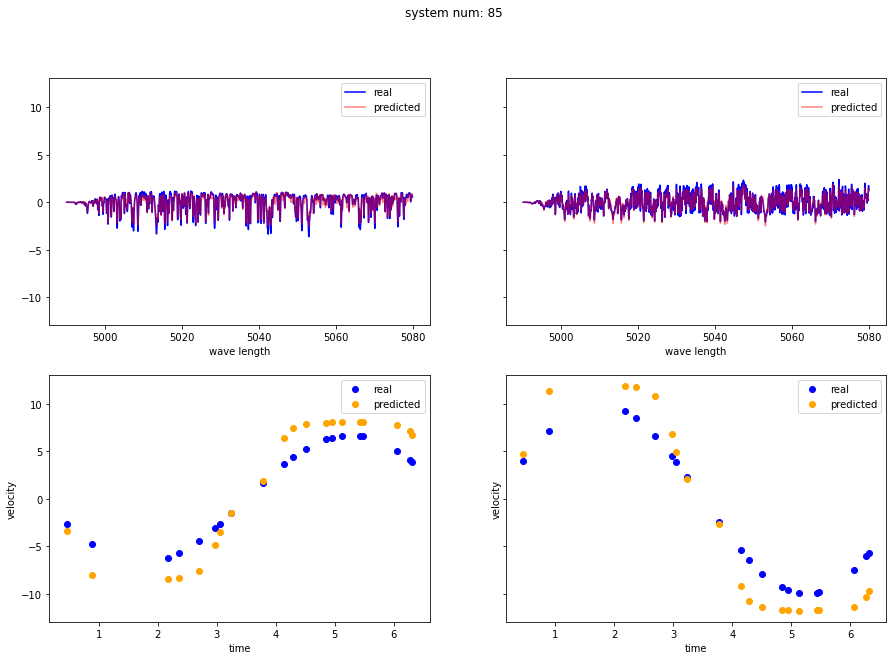

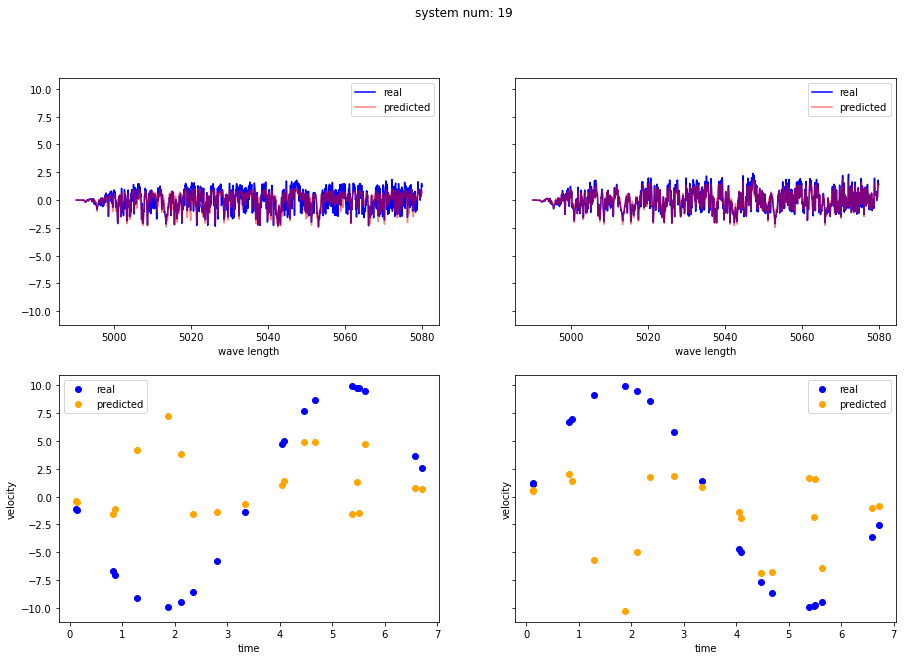

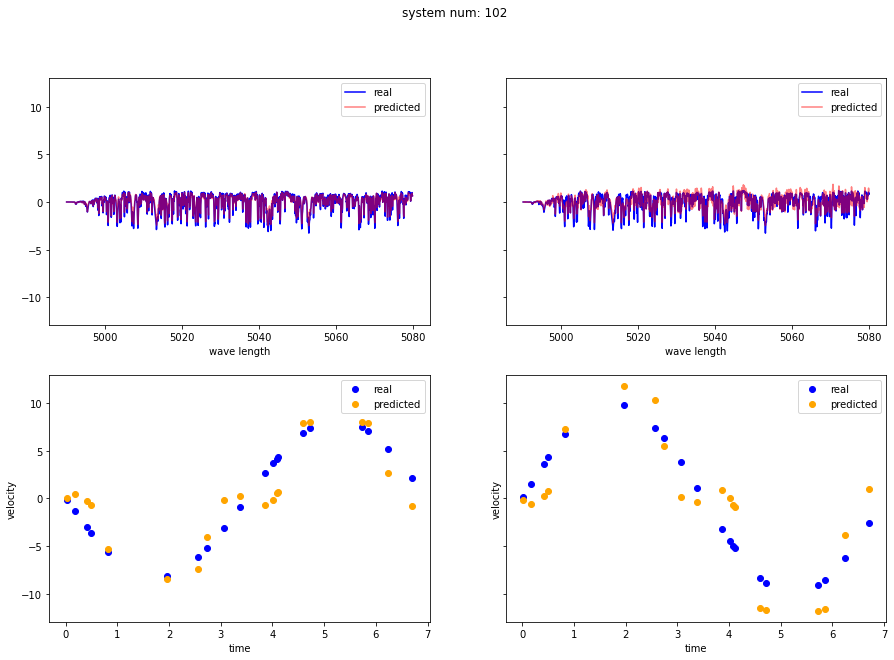

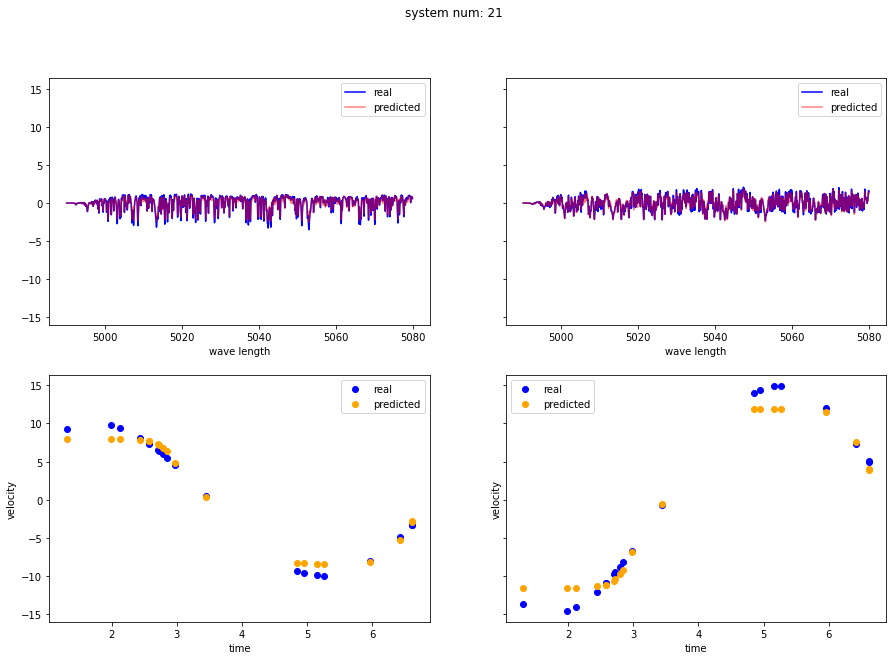

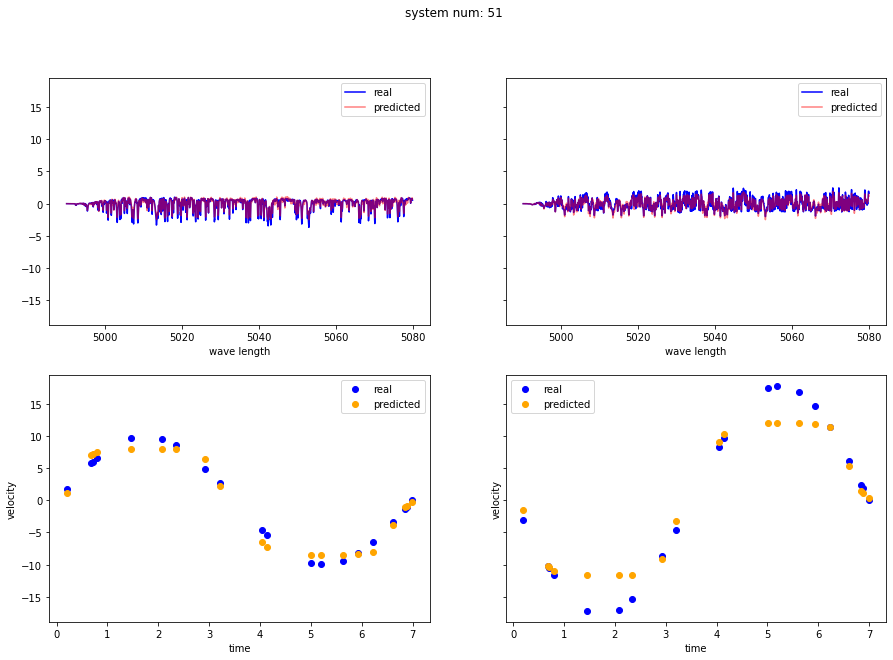

In [9]:
training.check_all_forward(pepe, mod, test_loader, 15, std_dict['vector target'])


## Training Parameters:

In [ ]:
del pepe
torch.cuda.empty_cache()

## Train new Model

In [ ]:
epochs_amount = 10
# spectraModel_test_big_drop = SpectraNet(drop=0.7).to(device)
opt = optim.Adam(pepe.parameters(), weight_decay = 1e-1,lr=2.5e-5) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//5)*3 and (epoch+1)%2 == 0 else 1
#lambda_lr = lambda epoch: 1 if epoch > epochs_amount//2 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
pepe, train_loss, val_loss = training.train_spectra1(pepe, opt, sched, train_loader, val_loader, epochs=epochs_amount)

In [22]:
Nets.save_model_with_checkpoint(dop_test, lr=0.0001, model_type='doppler', name='together')

In [ ]:
plt.figure()
plt.plot(range(epochs_amount), train_loss, label = 'train')
plt.plot(range(epochs_amount), val_loss, label = 'validation')
plt.legend()

In [ ]:
training.check_spectra_model(pepe, val_loader, 10, std_dict['vector target'])

## Test all forward


In [40]:
training.check_doppler_model(mod_sep, train_loader, 10)

NameError: name 'val_loader' is not defined

### Snippet to draw and test shape closeness

In [ ]:
loss = nn.MSELoss(reduction = 'mean')
pepe.eval()
length = 90
skip = True
s1 = list(range(length))
s2 = list(range(length))
spec1 = list(range(length))
spec2 = list(range(length))
j = 0
k = j+3
running_loss = 0
with torch.no_grad():
    h = pepe.init_hidden()
    for i, (obs,specs,system,_,_) in enumerate(val_loader):
#         if i >= 10:
#             break
        specs = specs.to(device)
        #spec1[i], spec2[i] = normalize_tensor(specs[0,:]), normalize_tensor(specs[1,:])
        spec1[i], spec2[i] = specs[0,:], specs[1,:]
        s1[i],s2[i],h = pepe(split_vector_to_seqs(obs, seq_length=500, seq_amount=7500//500).to(device), h)
        #s1[i] = normalize_tensor(s1[i])
        #s2[i] = normalize_tensor(s2[i])
        running_loss += training.calc_loss(loss, s1[i],s2[i],spec1[i].view(1,-1),spec2[i].view(1,-1)).item()
        if i < 10:
            display_graphs(loss,s1[i][0],s2[i][0],spec1[i][:],spec2[i][:],std_dict['vector target'],system)

print(f'test loss: {running_loss / len(val_loader)}')
loss = nn.MSELoss(reduction = 'mean')
print(loss(s2[j], s2[k]))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (15, 5))
ax1.plot(std_dict['vector target'], s2[j][0].cpu().detach().numpy(), color='blue', label = f's2[{j}]')
ax1.plot(std_dict['vector target'], s2[k][0].cpu().detach().numpy(), alpha = 0.5, color='red', label = f's2[{k}]')
ax1.legend()
print(loss(spec2[j], spec2[k]))
ax2.plot(std_dict['vector target'], spec2[j].cpu().detach().numpy(), color='blue', label = f'spec2[{j}]')
ax2.plot(std_dict['vector target'], spec2[k].cpu().detach().numpy(), alpha = 0.5, color='red', label = f'spec2[{k}]')
ax2.legend()
# print(loss(s2[0], s2[1]))
# print(loss(spec2[0], spec2[1]))

In [ ]:
spectraModel_test_big_drop.eval()
real = get_real_loader(std_dict)
print(real[1])
with torch.no_grad():
    loss_function = nn.MSELoss(reduction = 'mean')
    h = spectraModel_test_big_drop.init_hidden()
    target = real[1].to(device)
    s1,s2,h = spectraModel_test_big_drop(split_vector_to_seqs(real[0], seq_length=500, seq_amount=7500//500).to(device), h)
    display_graphs(loss,s1[0],s2[0],target[0,:],target[1,:],std_dict['vector target'])
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize = (15, 5))
    #ax1.plot(real[1][0,:].cpu().numpy(), color='blue')
    #ax2.plot(real[1][1,:].cpu().numpy(), color='blue')
    #ax3.plot(s2[0].cpu().numpy(), color='red')
    #ax4.plot(s1[0].cpu().numpy(), color='red')
    print(calc_loss(loss_function,s1.cpu(),s2.cpu(),target[0,:].view(1,-1).cpu(), target[1,:].view(1,-1).cpu()))

In [ ]:
print(std_dict)

In [ ]:
test = SpectraNet()
req_grad = False
opt = torch.optim.Adam(test.parameters())
for param in test.parameters():
    if param.size() == torch.Size([1995, 1995]): # the params from here are the last layer and its bias
        req_grad = True
    param.requires_grad = req_grad
print(opt)
# for param in opt.params:
#     print(f'param: required grad: {param.requires_grad}, size: {param.size()}')

In [ ]:
doppy = Nets.DopplerNet(batch_size = 40).to(device) #40 because there are 20 observation but 2 systems to predict so: 20*2
opt = optim.Adam(doppy.parameters(), weight_decay=1e-2, lr=0.00011)
epochs_amount = 15
lambda_lr = lambda epoch: 0.5 if epoch+1 > (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
#lambda_lr = lambda epoch: 1 if epoch > epochs_amount//2 else 1
schedu = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
print(doppy)
doppy, tr, vl = training.train_doppler25(pepe, doppy, opt, schedu, train_loader, val_loader, epochs=epochs_amount)

In [ ]:
plt.figure()
plt.plot(tr, label = 'training')
plt.plot(vl, label = 'validation')
plt.legend()

In [ ]:
it = iter(val_loader)
tup = next(it)
tup = next(it)
tup = next(it)
tup = next(it)
tup = next(it)
# tup = next(it)
repeat_time = 7
print(len(tup))
doppy.eval()
with torch.no_grad():
#     spec1, spec2, _ = spectraModel(split_vector_to_seqs(tup[0]).to(device), spectraModel.init_hidden())
#     inp = torch.cat((tup[0].repeat(2,1),torch.cat((spec1.cpu().repeat(20,1), spec2.cpu().repeat(20,1)), 0)), 1)
    inp = torch.cat((tup[0].repeat(2,1),torch.cat((tup[1][0,:].repeat(20,1), tup[1][1,:].repeat(20,1)), 0)), 1)
    predicted, _ = doppy(split_vector_to_seqs(inp, doppy.seq_size, doppy.seq_amount,
                                                    doppy.combine_wave_input).to(device), doppy.init_hidden())
    predicted = predicted.view(2,20)
    print(predicted.shape)
#     plt.figure(figsize = [6,4])
#     plt.scatter(tup[3]%8, predicted[0,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3]%8, tup[4][0,:].numpy(), color='blue')
#     plt.figure(figsize = [6,4])
#     plt.scatter(tup[3], predicted[1,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3], tup[4][1,:].numpy(), color='blue')
    plt.figure(figsize = [10,5])
#     plt.scatter(tup[3], predicted[0,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3], predicted[1,:].cpu().numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, tup[4][0,:].numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, predicted[0,:].cpu().numpy(), color='orange')
    plt.figure(figsize = [10,5])
    plt.scatter(tup[3]%repeat_time, tup[4][1,:].numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, predicted[1,:].cpu().numpy(), color='orange')


In [ ]:
dop_new = Nets.load_model_from_mode('doppler', True, drop=0.5, lr=0.00011)

In [ ]:
# dop_new = dop_new.to(device)
loss_function = nn.MSELoss(reduction = 'mean')
repeat_time = 7
doppy.eval()
with torch.no_grad():
    running_loss = 0
    for i, (obs, specs, system_id, times, velocities) in enumerate(test_loader):
        doppler_hidden = doppy.init_hidden()

        doppler_input = torch.cat((obs.repeat(2,1),
                                   torch.cat(
                                       (specs[0,:].repeat(20,1), specs[1,:].repeat(20,1)),0)),1)

        doppler_input = split_vector_to_seqs(doppler_input, doppy.seq_size, doppy.seq_amount,
                                             doppy.combine_wave_input).to(device)
        output, doppler_hidden = doppy(doppler_input, doppler_hidden)
        #output = output.view(2,20)
        output = torch.transpose(output, 0,1)
        velocities = velocities.to(device)
        loss = loss_function(output[0,:], velocities[0,:]) + loss_function(output[1,:], velocities[1,:])
#         loss = calc_loss(loss_function, output[0,:],output[1,:],velocities[0,:], velocities[1,:])
        running_loss += loss.item()
        if i < 10:
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
            ax1.scatter(times%repeat_time, velocities[0,:].cpu().numpy(), label='real', color='blue')
            ax1.scatter(times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
            ax2.scatter(times%repeat_time, velocities[1,:].cpu().numpy(), label='real', color='blue')
            ax2.scatter(times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
            f.suptitle(f'system num: {system_id}')
            ax1.set_xlabel('time')
            ax2.set_xlabel('time')
            ax1.set_ylabel('velocity')
            ax2.set_ylabel('velocity')
            ax1.legend()
            ax2.legend()

#             f2, (ax3, ax4) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
#             ax3.scatter(times%repeat_time, velocities[0,:].cpu().numpy(), label='real', color='blue')
#             ax3.scatter(times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
#             ax4.scatter(times%repeat_time, velocities[1,:].cpu().numpy(), label='real', color='blue')
#             ax4.scatter(times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
#             f2.suptitle(f'system num: {system_id}')
#             ax3.set_xlabel('time')
#             ax4.set_xlabel('time')
#             ax3.set_ylabel('velocity')
#             ax4.set_ylabel('velocity')
#             ax3.legend()
#             ax4.legend()
    print(f'total loss: {running_loss/len(train_loader)}')

In [ ]:
Nets.save_model_with_checkpoint(doppy, 0.00012, 'doppler')

## Test the real star velocity, it's an exentric star (not like the ones in our data - very different) and we are still getting pretty good results

(tensor([[ 0.8322,  0.8433,  0.8500,  ...,  0.5940,  0.5917,  0.6783],
        [ 0.6484,  0.6398,  0.5845,  ..., -0.0543,  0.0072,  0.0822],
        [ 0.0144, -0.6143, -0.9174,  ..., -0.8048, -0.2096,  0.1718],
        ...,
        [ 0.5665,  0.4677,  0.3852,  ..., -0.2666, -0.3012, -0.4262],
        [ 0.3011,  0.3447, -0.0037,  ...,  0.7311,  0.5711,  0.4764],
        [ 0.6429,  0.5702,  0.2001,  ..., -0.0819,  0.0257, -0.5270]]), tensor([[4.0049e-07, 1.7829e-06, 4.1127e-06,  ..., 5.4825e-01, 3.8845e-01,
         3.8846e-01],
        [4.4857e-07, 1.9827e-06, 4.5738e-06,  ..., 8.8592e-01, 6.7519e-01,
         6.6624e-01]], dtype=torch.float64))
tensor([[-1.4810,  4.9130,  4.3439,  1.8752,  3.3510,  3.4983,  5.0872,  5.8796,
          0.7291,  2.3900,  2.3318,  2.0758,  5.6036, -2.2505,  1.5734,  3.1363,
          2.0447,  3.8351,  6.4245, -0.1595],
        [ 1.4444, -4.4917, -3.2371, -1.5081, -2.4427, -1.7384, -3.8885, -3.7905,
         -0.4045, -1.8023, -1.5975, -1.2373, -5.2925,  2.1

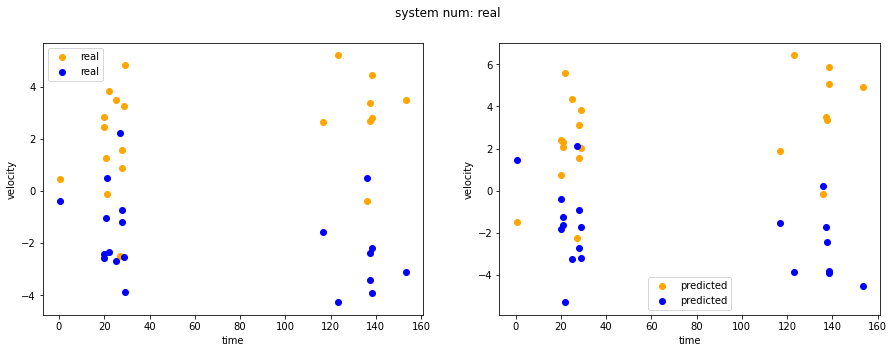

In [13]:
real = get_real_loader(std_dict)
print(real)
times = range(20)
# print(real[1])
repeat_time = 7

new_times = torch.tensor([0.5258358498103917,
 311.78148982999846,
 341.84771745977923,
 433.56606571003795,
 1087.7946868599392,
 1087.6849441300146,
 1088.5976183298044,
 1088.6789588402025,
 1128.6752032698132,
 1128.5791229400784,
 1129.6505303801969,
 1129.5734185199253,
 1130.54320129985,
 1135.6618717098609,
 1136.5898129399866,
 1136.6504905801266,
 1137.620776989963,
 1137.5821229401045,
 1548.5132086100057,
 1561.4949623998255])
ttt = [0.5258358498103917,311.78148982999846,341.84771745977923,433.56606571003795,1087.7946868599392,1087.6849441300146,1088.5976183298044,1088.6789588402025,1128.6752032698132,1128.5791229400784,1129.6505303801969,1129.5734185199253,1130.54320129985,1135.6618717098609,1136.5898129399866,1136.6504905801266,1137.620776989963,1137.5821229401045,1548.5132086100057,1561.4949623998255,1563.4780927198008]

with torch.no_grad():
    loss_function = nn.MSELoss(reduction = 'mean')
    doppler_hidden = mod_sep.init_hidden()

    doppler_input = (torch.cat((real[0].repeat(2,1),
                               torch.cat(
                                   (real[1][0,:].repeat(20,1), real[1][1,:].repeat(20,1)),0)),1)).type(torch.FloatTensor)

    doppler_input = split_vector_to_seqs(doppler_input, mod.seq_size, mod.seq_amount,
                                         mod.combine_wave_input).to(device)
    output, doppler_hidden = mod_sep(doppler_input, doppler_hidden)
    #output = output.view(2,20)
    output = torch.transpose(output, 0,1)
#     velocities = velocities.to(device)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
    ax2.scatter(new_times%158.38, output[0,:].cpu().numpy(), label='predicted', color='orange')
    ax2.scatter(new_times%158.38, output[1,:].cpu().numpy(), label='predicted', color='blue')
    ax1.scatter(new_times%158.38, [ 0.4807,  3.4946,  3.4890,  2.6325,  3.3601,  2.6683,  2.7920,  4.4577,
          2.4410,  2.8286, -0.1037,  1.2503,  3.8465, -2.4791,  1.5586,  0.8806,
          4.8355,  3.2758,  5.2041, -0.3927], label='real', color='orange')
    ax1.scatter(new_times%158.38, [-0.3747, -3.0976, -2.6736, -1.5612, -3.4014, -2.3724, -2.1985, -3.9267,
         -2.5787, -2.4000,  0.5146, -1.0211, -2.3276,  2.2298, -1.1851, -0.7104,
         -3.8605, -2.5371, -4.2727,  0.4841], label='real', color='blue')
    f.suptitle(f'system num: {"real"}')
    ax1.set_xlabel('time')
    ax2.set_xlabel('time')
    ax1.set_ylabel('velocity')
    ax2.set_ylabel('velocity')
    ax1.legend()
    ax2.legend()
    print(output)


# Test Functions and Code Slices

In [ ]:
b = torch.randn(4,52)
print(b.size())
b = b[:, :50]
print(b.size())
seq_temp = 5
print(b.dim)
b = b.view(-1, b.size()[-1]//seq_temp, seq_temp)
print(b.size())
b.view

In [ ]:
dataloader = getLoader()
test = next(iter(dataloader))
for item in test:
    if type(item) is int:
        print(item)
    else:
        if item.size()[-1] >= 50:
            item = split_vector_to_seqs(item)
            item = combine_seqs_to_vector(item)
        print(item.shape)

In [ ]:
a = torch.randn(5,5)
z = torch.zeros(5,2)
print(torch.cat((a, z), 1))
print(a.size(), a)
print(a[-5:])

tr = torch.zeros(20, 153, 50)
tr = tr.view(-1, 153*50)
print(tr.size())

In [ ]:
check = torch.ones(3)
print(f'check: {3 in check}')

In [ ]:
train, test, val = getLoader()

for a,b,c,d,e in train:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is train')
for a,b,c,d,e in test:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is test')
for a,b,c,d,e in val:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is val')

In [ ]:
def find_factors(num: int):
    divs = []
    for div in range(5,num//2, 5):
        if num%div == 0:
            divs.append(div)
    print(divs)

In [ ]:
find_factors(9200)

In [ ]:
a = torch.randint(40,(20,2))
b1, b2 = torch.randint(40,(1,2)), torch.randint(40,(1,2))
# b.fill_(a)
print(a.shape)
print(b1.shape, b2.shape)
doppler_input = torch.cat((a.repeat(2,1), torch.cat((b1.repeat(20,1), b2.repeat(20,1)), 0)), 1)
print(type(doppler_input), len(doppler_input), doppler_input.shape)

In [17]:
class SpectraNet2(nn.Module):
    def __init__(self, with_drop=True, hidden_size=hp.hidden_size, n_layers=hp.num_layers_spectra, drop=hp.drop_spectra, 
                 batch_size=hp.batch_size, wave_amount=hp.observation_amount, seq_size=hp.wave_sequence_length, 
                 output_amount=hp.wave_output, seq_amount=hp.wave_seq_amount):
        super(SpectraNet2, self).__init__()
        self.with_drop = with_drop
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.drop = drop
        self.batch_size = batch_size
        self.wave_amount = wave_amount
        self.output_amount = output_amount
        self.seq_size = seq_size
        self.seq_amount = seq_amount
        self.hidden_layer_size = int(self.wave_amount/2)
        self.conv1 = nn.Sequential(nn.Conv2d(1,4, kernel_size = 5, stride = 2),
                                   nn.ReLU()) # 1*1*20*15000 -> 1*4*8*7498
        self.conv2 = nn.Sequential(nn.Conv2d(4,8, kernel_size = 5, stride = 2),
                                   nn.ReLU())
        
        self.pool = nn.AvgPool2d(kernel_size = (1,4)) #1*4*8*7498 -> 1*8*2*3747/2
        self.convfc = nn.Sequential(nn.Linear(14976,8000),
                                    nn.ReLU(),
                                    nn.Dropout(drop))
        self.convfc1 = nn.Linear(8000, self.output_amount)
        self.convfc2 = nn.Linear(8000 + self.output_amount, self.output_amount)
        if with_drop == True:
            self.rnn = nn.LSTM(self.seq_size, hidden_size, n_layers,
                               dropout=drop, batch_first=True, bidirectional=True)
            self.attention = nn.MultiheadAttention(seq_size, num_heads=1, dropout=drop)
            self.dropout = nn.Dropout(drop)
            '''should take the whole RNN outpur vector (concatanate the outputs from each lstm-cell-forward_pass) and feed it to one FC'''
            self.fc1 = nn.Sequential(nn.Linear(self.wave_amount, self.hidden_layer_size),
                                    nn.ReLU(),
                                    self.dropout,
                                    nn.Linear(self.hidden_layer_size, self.output_amount))
            self.fc2 = nn.Linear(self.output_amount, self.output_amount)
        
    def forward(self, spectra, hidden, method: int = 3):
        '''     
        1. sum the losses of each spectra and then backprop - I think it will backprop in the net twice
        (for each spectra)
        2. train the first layers until spectra1 and then only the last FC on the spectra2 with all the
        others params grad's are off
        '''
        if self.with_drop: 
            spectra = self.dropout(spectra)
        spectra, hidden = self.rnn(spectra, hidden)
        print(f'after RNN: {spectra.shape}')
        if self.with_drop:
            spectra = self.dropout(spectra)
        '''To give the attention input we need to view it in: seq_amount X batch_size X seq_length'''
#         ##spectra = spectra.reshape(self.seq_amount, self.batch_size, self.seq_size)
#         ##spectra, _ = self.attention(spectra, spectra, spectra, need_weights=False)
#         ##spectra = spectra.reshape(self.batch_size, self.seq_amount, self.seq_size)
        spectra = combine_seqs_to_vector(spectra.contiguous(), self.wave_amount)
        print(f'combined to single: {spectra.shape}')
        if method == 3:
            spectra = spectra.view(1,1,spectra.shape[0],spectra.shape[1])
            print(f'input to conv: {spectra.shape}')
            spectra = self.conv1(spectra)
            print(f'after conv 1: {spectra.shape}')
            spectra = self.conv2(spectra)
            print(f'after conv 2: {spectra.shape}')
            spectra = self.pool(spectra)
            print(f'after pooling : {spectra.shape}')
            spectra = spectra.view(spectra.shape[0],-1)
            print(f'input to fully-connected: {spectra.shape}')
            spectra = self.convfc(spectra)
            print(f'after 1 FC: {spectra.shape}')
            final_spectra1 = self.convfc1(spectra)
            print(f'final spectra1 : {final_spectra1.shape}')
            for_second = torch.cat((spectra, final_spectra1), 1)
            print(f'shape for second: {for_second.shape}')
            final_spectra2 = self.convfc2(for_second)
            print(f'final spectra2 : {final_spectra1.shape}')
            return final_spectra1, final_spectra2, hidden
    def forward_method_2(self, spectra1):
        '''
        need to be called only after we finished training the first part
        '''
        return torch.mean(self.fc2(spectra1.detach().view(1,-1)), dim=0) #the batch dim - might need to also resize it to get rid of this dim
    def init_hidden(self):
        weight = next(self.parameters()).data
        if device == 'cuda':
            # 2* because we are bidirectional
            hidden = (weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_().cuda(),
                      weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_().cuda())
        else:
            hidden = (weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_(),
                      (weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_()))
        
        return hidden


In [23]:
test_print = SpectraNet2().to(device)

In [24]:
for obs, _, _, _, _ in train_loader:
    seq_size, seq_amount, wave_amount = test_print.seq_size, test_print.seq_amount, test_print.wave_amount
    obs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device)
    _,_,_ = test_print(obs, test_print.init_hidden(), method=3)
    break

after RNN: torch.Size([20, 15, 1000])
combined to single: torch.Size([20, 15000])
input to conv: torch.Size([1, 1, 20, 15000])
after conv 1: torch.Size([1, 4, 8, 7498])
after conv 2: torch.Size([1, 8, 2, 3747])
after pooling : torch.Size([1, 8, 2, 936])
input to fully-connected: torch.Size([1, 14976])
after 1 FC: torch.Size([1, 8000])
final spectra1 : torch.Size([1, 1700])
shape for second: torch.Size([1, 9700])
final spectra2 : torch.Size([1, 1700])


In [35]:
def check_all_forward_optimal(spectra_net: Nets.SpectraNet, doppler_net: Nets.DopplerNet, data, plot_amount:int = 10, std_vec = None):
    repeat_time = 7
    spectra_net.eval()
    doppler_net.eval()
    loss_function = nn.MSELoss(reduction = 'mean')
    sample_amount = len(data)
    spec_seq_size, spec_seq_amount, spec_wave_amount = spectra_net.seq_size, spectra_net.seq_amount, spectra_net.wave_amount
    dop_seq_size, dop_seq_amount, dop_input_length = doppler_net.seq_size, doppler_net.seq_amount, doppler_net.combine_wave_input 
    
    spec_running_loss = 0
    dop_running_loss = 0
    with torch.no_grad():
        for i, (observ, specs, c, times, vel) in enumerate(data):
            spec_hidden = spectra_net.init_hidden()
            dop_hidden = doppler_net.init_hidden()
            obs, specs = split_vector_to_seqs(observ, spec_seq_size, spec_seq_amount, spec_wave_amount).to(device), specs.to(device)
            spec_out = spectra_net(obs, spec_hidden, method=3)
            spec_hidden = spec_out[2]
            loss, direction = calc_loss(loss_function, spec_out[0], spec_out[1], specs[0,:].view(1, -1), specs[1,:].view(1, -1))
            spec_running_loss += loss.item()
            
#             doppler_input = torch.cat((observ.to(device).repeat(2,1),
#                                   torch.cat((specs[direction,:].repeat(20,1), specs[1-direction,:].repeat(20,1)), 0)), 1)
            doppler_input = torch.cat((observ.to(device).repeat(2,1),
                                  torch.cat((spec_out[0][0].repeat(20,1), spec_out[1][0].repeat(20,1)), 0)), 1)

#             print(f'spectra1 size: {spectra1.size()}, specs: {specs[:, 0].size()}')
            output, doppler_val_hidden = doppler_net(split_vector_to_seqs(doppler_input, dop_seq_size, dop_seq_amount,
                                                                      dop_input_length).to(device), dop_hidden)
            output = torch.transpose(output,0,1)
            vel = vel.to(device)
#             '''HERE WE DO NEED THAT THE 1st VELOCITY WOULD CORRESPOND TO THE 1st OUTPUT AND VISE VERSA'''
#             loss = loss_function(output[0,:], vel[direction,:]) + loss_function(output[1,:], vel[1-direction,:])
            loss, dop_direction = calc_loss(loss_function, output[0,:], output[1,:], vel[0,:], vel[1,:])
#             loss = loss_function(output, velocities.to(device))
            dop_running_loss += loss.item()
    
            if i < plot_amount:
                f, ax = plt.subplots(2, 2, sharey=False, figsize = (15, 10)) 
                # gen_a -> real_a, gen_b -> real_b
                ax[0,0].plot(std_vec, specs[direction,:].cpu().numpy(), color='blue', label = 'real')
                ax[0,1].plot(std_vec, specs[1-direction,:].cpu().numpy(), color='blue', label = 'real')
                ax[0,0].plot(std_vec, spec_out[0][0].cpu().numpy(), color='red', alpha = 0.5, label = 'predicted')
                ax[0,1].plot(std_vec, spec_out[1][0].cpu().numpy(), color='red', alpha = 0.5, label = 'predicted')
                ax[1,0].scatter(times%repeat_time, vel[dop_direction,:].cpu().numpy(), color='blue', label='real')
                ax[1,1].scatter(times%repeat_time, vel[1-dop_direction,:].cpu().numpy(), color='blue', label='real')
                ax[1,0].scatter(times%repeat_time, output[0,:].cpu().numpy(), color='orange', label='predicted')
                ax[1,1].scatter(times%repeat_time, output[1,:].cpu().numpy(), color='orange', label='predicted')
                ax[1,0].set_xlabel('time')
                ax[1,1].set_xlabel('time')
                ax[1,0].set_ylabel('velocity')
                ax[1,1].set_ylabel('velocity')
                ax[1,0].legend()
                ax[1,1].legend()
                f.suptitle(f'system num: {c}')
                ax[0,0].set_xlabel('wave length')
                ax[0,1].set_xlabel('wave length')
                ax[0,0].legend()
                ax[0,1].legend()
        spec_avg_loss = spec_running_loss/len(data)
        dop_avg_loss = dop_running_loss/len(data)
        print("Spectra Loss: {:.4f}...".format(spec_avg_loss),
             "Doppler Loss: {:.4f}...".format(dop_avg_loss))
    return spec_avg_loss, dop_avg_loss

